In [1]:
%ls

define_column.py*            lrs_goldengate_EDA.ipynb*  README.md*
landsend_veg_2007_2012.csv*  preprocess.ipynb*


## first import packages needed

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("landsend_veg_2007_2012.csv")
df.head()

,Site-YearCode,Transect,Point,Height,Species,Plant code,Native Status,Life History,Stature
0,NUWO-2012,5,90,Low,-,-,-,-,-
1,NUWO-2012,13,150,Low,-,-,-,-,-
2,NMS-2010,8,20,Low,Achillea millefolium,ACMI,Native,Perennial,Forb
3,NMS-2010,24,4,Low,Achillea millefolium,ACMI,Native,Perennial,Forb
4,NMS-2010,48,16,Low,Achillea millefolium,ACMI,Native,Perennial,Forb


this is a wrong data point (**"SUDO-2014"**) according to Naomi, please delete it!

In [4]:
valid = df["Site-YearCode"] == "SUDO-2014"
df.loc[valid]

,Site-YearCode,Transect,Point,Height,Species,Plant code,Native Status,Life History,Stature


 count the frequencies of species in the data set

In [5]:
species = df[["Species"]].copy()
species["counts"] = 1
species_freq = species.groupby("Species").agg(sum).iloc[:,0].copy()
species_freq.sort(ascending=False)

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


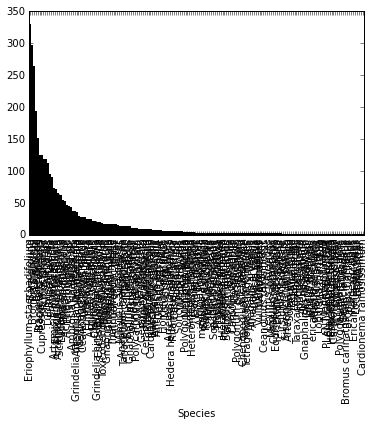

In [6]:
species_freq.plot(kind = "bar")
pass

Extract the **columns** we need (`"Site-YearCode"`, `"Species"`), and take **rows** which have no missing values ("-")

In [7]:
df_yr_sp = df[["Site-YearCode", "Species"]]
valid = ~ df_yr_sp.applymap( lambda x: x == "-").any(axis=1)
df_yr_sp = df_yr_sp.loc[valid]

split the `Site-YearCode` column into `site` and `year` columns

In [8]:
get_year = lambda x : int(x.split("-")[-1])
df_yr_sp["year"] = df_yr_sp["Site-YearCode"].map( get_year )

get_site = lambda x : (x.split("-")[0])
df_yr_sp["site"] = df_yr_sp["Site-YearCode"].map( get_site )

df_yr_sp.drop("Site-YearCode", axis=1, inplace = True)
df_yr_sp.head()

,Species,year,site
2,Achillea millefolium,2010,NMS
3,Achillea millefolium,2010,NMS
4,Achillea millefolium,2010,NMS
5,Achillea millefolium,2010,NMS
6,Achillea millefolium,2011,NMS


toy example: iterate over site and year groups:

In [9]:
for kk, vv in df_yr_sp.groupby(["site", "year"]):
    print(kk, vv["Species"].unique().shape[0] )

('EAPO', 2011) 31
('NMS', 2010) 45
('NMS', 2011) 35
('NMS', 2012) 54
('NUWO', 2010) 54
('NUWO', 2011) 25
('NUWO', 2012) 47
('SUDU', 2008) 33
('SUDU', 2009) 40
('SUDU', 2010) 35
('SUDU', 2011) 31
('SUDU', 2012) 41
('SUDU', 2013) 4


In [10]:
spnum = df_yr_sp.groupby(["site", "year"]).agg("count")
spnum.head()

Species
site year         
EAPO 2011      390
NMS  2010      247
     2011      175
     2012      335
NUWO 2010      320

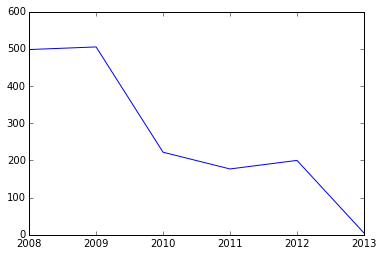

In [11]:
tt = spnum.loc["SUDU"].reset_index()["year"]
yy = spnum.loc["SUDU"]
plt.plot(tt, yy)

x_formatter = plt.matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.gca().xaxis.set_major_formatter(x_formatter)

In [ ]:
pd.pivot_table?

In [35]:
cols = ["Species","year", "site"]
df_yr_sp["count"] = 1
pd.pivot_table(
df_yr_sp.groupby(cols).agg("count").reset_index().\
drop("site", axis = 1).groupby(["Species","year"]).\
agg(sum).reset_index(), column = "Species", index = "year")

TypeError: pivot_table() got an unexpected keyword argument 'column'